# Try to extract user activities from logs:

* tab-open/close/open-in-new
* tab-switch
* link-click
* form-submit (which could be a way to submit search query)
* search query 
* pageView 

### Using context to determine these activities
* Once determined, the log can be reduced to sequences of these activities, as many other events are consequences of users operting one of these activities
* pageView needs to be derived from context, surrounding tab-load
* Next step is to assign task labels to these activities, propagate from tab-search and tab-load, both are results of certain user activities that are not explicitly visible from the log.

In [77]:
%matplotlib inline
from pymongo import MongoClient
import pymongo
import numpy as np
import itertools
import matplotlib.pylab as pylab
from scipy.stats import chi2_contingency

# DB connections
client = MongoClient()
db = client.db_tasklog_clean
# Collections
User = db.user
Log = db.log_chrome

# users
allUsers = list(User.find({}))

In [78]:
userLogs = {}
for u in allUsers:
    user_log = Log.aggregate([
        {'$match': {'userid': u['userid'], 'removed': False}},
        {'$project': {'affected_tab_id': 1, 
                     'event': 1, 
                     'url': 1,
                     'timestamp_bson': 1, 
                     'taskname': {'$ifNull': ['$annotation.task.name', 'NA']},
                     'taskid': {'$ifNull': ['$annotation.task.taskid', 'NA']},
                     'title': {'$ifNull': ['$details.current_tab.title', 'NA']},
                     }}, 
        {'$sort':{'timestamp_bson': pymongo.ASCENDING}},
        ])
    userLogs[u['userid']] = list(user_log)
        

## Split the log by time
### purpose: to identify groups of events due to chrome logging mechansim
* Long time inactivity between events cannot form system level event patterns

### Check time gap distribution between consecutive events

Large gaps Median: 1.041
25 QT: 0.228
75 QT: 4.256
95 RT: 46.68245


(array([  9.63500000e+03,   2.30000000e+01,   4.00000000e+00,
          3.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  1.79350000e+01,   5.37370674e+04,   1.07456200e+05,
          1.61175332e+05,   2.14894465e+05,   2.68613597e+05,
          3.22332729e+05,   3.76051862e+05,   4.29770994e+05,
          4.83490127e+05,   5.37209259e+05]),
 <a list of 10 Patch objects>)

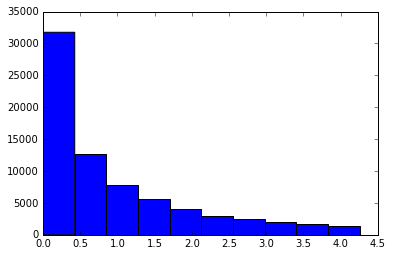

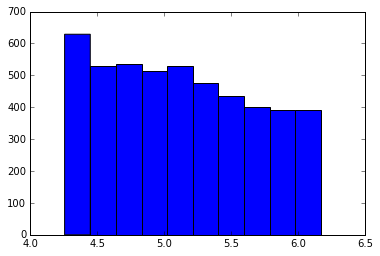

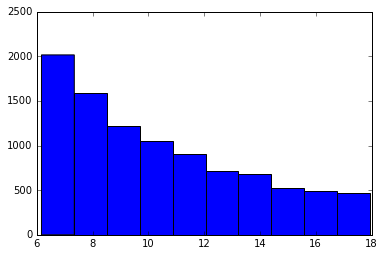

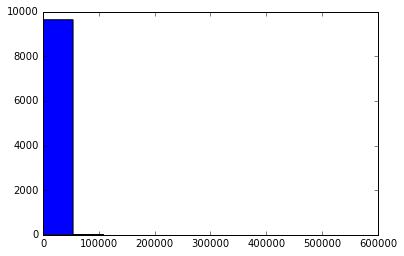

In [79]:
gap = []
large_gap = []
for u in userLogs:
    ulog = userLogs[u]
    for l in range(len(ulog)):
        if l > 0:
            timediff = (ulog[l]['timestamp_bson'] - ulog[l-1]['timestamp_bson']).total_seconds()
            gap.append(timediff)
            # check for events that have a gap > 1 min
            if timediff > 60*5:
                large_gap.append((ulog[l-1]['event'], ulog[l]['event']))
          
print 'Large gaps', 
G = [g[0] + ' ' + g[1] for g in large_gap]
G.sort()
freq = []
for k, g in itertools.groupby(G):
    gg = list(g)
    if len(gg) > 1:
        freq.append((k, len(gg)))
freq.sort(reverse=True, key=lambda x: x[1])
#for f in freq:
#    print f


gap.sort()
print 'Median:', np.median(gap)
print '25 QT:', np.percentile(gap, 25)
print '75 QT:', np.percentile(gap, 75)
print '95 RT:', np.percentile(gap, 95)

pc_75 = gap[0:len(gap)/4*3]
pc_75_80 = gap[len(gap)/4*3:len(gap)/10*8]
pc_80_90 = gap[len(gap)/10*8:len(gap)/10*9]
pc_90_100 = gap[len(gap)/10*9:]
pylab.figure()
pylab.hist(pc_75)
pylab.figure()
pylab.hist(pc_75_80)
pylab.figure()
pylab.hist(pc_80_90)
pylab.figure()
pylab.hist(pc_90_100)

### Split by time
* It is unlikely that a system level has a gap between events > 5 mins (It is likely that some page needs sometime to load, 5 mins is a conservative thresh)
* 95% of the consecutive events happend under 46.8 seconds
* Split the log by 5 mins gap

### Determine what leads to tab-search
* Statistical methods are not very reliable. 
* tab-serach is detected when there is a URL change. 
* Special situations: 
    1. forward-backward action that leads to reload of a SERP. In this case, we can optionally skip the query as users did not actually re-issue the query.
        * tab-search -> navigation-omni_query-foward_back (google)
        * tab-search -> navigation-form_submit (bing) this is the same as re-submitting unfortunately (although not many queries were submitted to bing)
        * For Yahoo, click a link in SERP opens a new tab, so no problem with forward/backward
    2. click "next page" of a SERP or click a different verticle. 
        * tab-search -> tab-loaded -> link_click (google)
        * tab-search -> link_click -> tab-search -> navigation-link -> tab-loaded (bing, yahoo) 
        * we should treat different verticle as different queries, next page as the same query

In [135]:
#to_trigger = ['tab-open', 'tab-close', 'tab-open-in-new', 'tab-switch', 'link-click', 'form-submit']
#be_triggered = ['tab-search', 'tab-loaded']

bigrams = []
unigrams = []
for u in userLogs:
    ulog = userLogs[u]
    for l in range(len(ulog)):
        unigrams.append(ulog[l]['event'])
        if l > 0:
            timediff = (ulog[l]['timestamp_bson'] - ulog[l-1]['timestamp_bson']).total_seconds()
            # If two events has a 5 minutes gap, they can't be system-level pattern
            if timediff < 1:
                bigrams.append((ulog[l-1]['event'], ulog[l]['event'], timediff))

bigrams.sort()
B = []
for k, g in itertools.groupby(bigrams, lambda x: (x[0], x[1])):
    B.append((k, len(list(g))))
unigrams.sort()
U = []
for k, g in itertools.groupby(unigrams):
    U.append((k, len(list(g))))
Bmap = dict(B)
Umap = dict(U)
# tab-search is detected when there is a url change
# check which events are likely to follow by tab-search
ts = list(itertools.ifilter(lambda x: x[0][0] == 'tab-search', B))
for b in ts:
    p_joint = b[1]/float(len(bigrams))
    p_independent = Umap[b[0][0]]/float(len(unigrams)) * Umap[b[0][1]]/float(len(unigrams))
    print b, p_joint/p_independent


((u'tab-search', u'link_click'), 10) 0.0591742479348
((u'tab-search', u'navigation-form_submit'), 54) 1.55312745963
((u'tab-search', u'navigation-link'), 656) 4.6642316119
((u'tab-search', u'navigation-link-forward_back'), 148) 10.3574063492
((u'tab-search', u'navigation-omni_query'), 495) 21.0112090645
((u'tab-search', u'navigation-omni_query-forward_back'), 175) 64.9437371084
((u'tab-search', u'navigation-omni_url'), 3) 0.0535103574088
((u'tab-search', u'navigation-reload'), 7) 0.881019689455
((u'tab-search', u'navigation-start_page'), 1) 0.811796713855
((u'tab-search', u'tab-loaded'), 1469) 3.17753629804
((u'tab-search', u'tab-switch'), 1) 0.00534032868255


## Check tab-loaded, when can we say a page is viewed
* SERP should not be counted as page-view
* If we group by tab-id, dewell time should be the time a user spend on the same tab, same url, check what's happending within the same tab
* We want to know when a page view is from SERP, when it's from typing in url, and when it's from link-navigation
   * directly url typing: navigation_omni_url -> tab-loaded
   * from SERP: link_click (on SERP) -> navigation_link -> tab-loaded
   * from non-SERP: follow the same path, but link_click does not start from a SERP url
* In google mail/calendar/drive, it can happen to have continuous tab-loaded, but they would be just operations on different parts of the same page
* In google search, a fixed pattern would occur:
   * navigation-omni_query (tab1) -> tab-replaced(tab2) -> tab-replace-switch (tab1) ->tab-search (tab1) 
   * may followed by link_click(tab1) -> navigation-link (tab1, url2) -> tab-loaded (tab1, url2)

In [142]:
for u in userLogs.keys()[1:2]:
    ulog = userLogs[u]
    # Group log by tab-id
    current_tab = 0
    tab = []
    for l in ulog:
        if not l['affected_tab_id'] == current_tab:
            print current_tab
            for t in tab:
                print t
            print
            tab = []
            current_tab = l['affected_tab_id']
        tab.append((l['event'], l['url']))




0

5
(u'tab-switch', u'http://tasklog.cs.ucl.ac.uk/users/instructions#software')
(u'tab-loaded', u'http://tasklog.cs.ucl.ac.uk/users/instructions#software')
(u'navigation-link', u'http://tasklog.cs.ucl.ac.uk/users/annotation')
(u'tab-loaded', u'http://tasklog.cs.ucl.ac.uk/users/annotation')

189
(u'tab-new', u'chrome://newtab/')
(u'tab-new-switch', u'chrome://newtab/')
(u'navigation-omni_url', u'https://www.google.co.uk/_/chrome/newtab?espv=2&es_th=1&ie=UTF-8')

187
(u'tab-close', u'')

5
(u'tab-switch', u'http://tasklog.cs.ucl.ac.uk/users/annotation')
(u'navigation-reload', u'http://tasklog.cs.ucl.ac.uk/users/annotation')
(u'tab-loaded', u'http://tasklog.cs.ucl.ac.uk/users/annotation')
(u'tab-switch', u'http://tasklog.cs.ucl.ac.uk/users/annotation')

193
(u'tab-new', u'chrome://newtab/')
(u'tab-new-switch', u'chrome://newtab/')
(u'navigation-omni_url', u'https://www.google.co.uk/_/chrome/newtab?espv=2&es_th=1&ie=UTF-8')
(u'navigation-link', u'https://www.tlscontact.com/gbLON2fr/splash